In [1]:
!pip install ohmeow-blurr -q
!pip install datasets -q

In [2]:
from fastai.text.all import *
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import *
from blurr.modeling.core import *

In [3]:
from blurr import __version__ as blurr_version
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using blurr {blurr_version}')
print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using blurr 0.0.25
Using pytorch 1.8.1+cu101
Using fastai 2.3.1
Using transformers 4.6.1


## Data

In [4]:
trn_ds, val_ds, tst_ds = load_dataset("amazon_reviews_multi", "de", split=['train', 'validation', 'test'])

Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [5]:
trn_df = pd.DataFrame(trn_ds)
val_df = pd.DataFrame(val_ds)
tst_df = pd.DataFrame(tst_ds)

:::{.callout-important}

Use a subset of the data when building your model to speed up developement time!

:::


After you got everything, throw the full dataset at it and go get some coffee :)

In [6]:
# testing with a subset ... (comment out to train on full dataset!!!)

# this won't work because the rows are ordered by our targets!
# trn_ds, val_ds = load_dataset("amazon_reviews_multi", "de", split=['train[:10%]', 'validation[:10%]'])

trn_df = trn_df.sample(frac=0.05)
val_df = val_df.sample(frac=0.05)

In [7]:
trn_df['is_valid'] = False; val_df['is_valid'] = True
df = pd.concat([trn_df, val_df])

print(len(trn_df), len(val_df), len(df))

10000 250 10250


In [8]:
trn_df.head()

,language,product_category,product_id,review_body,review_id,review_title,reviewer_id,stars,is_valid
115812,de,apparel,product_de_0727194,"für so einen Preis muss ich dazusagen, es hält was es verspricht, natürlich ist hier keine hohe Qualität zu erwarten, aber für solchen Preis recht gut. ist. Die Nähte gehen mit Zeit auf",de_0580512,Preis Leistung Ok,reviewer_de_0542714,3,False
58074,de,toy,product_de_0014211,Die Qualität ist nicht gut. Nur nach kurzem nutzen sind die plastikverkleidungen abgefallen. Der Ball lässt sich schlecht für Kinder entfernen. Die Scheiben sehen nach kurzer Nutzung aus als wären sie Jahre im Gebrauch. Würde ich nicht wieder kaufen.,de_0100470,Schlechte Qualität,reviewer_de_0719961,2,False
122195,de,toy,product_de_0304268,Erfüllt seinen Zweck und sie gut aus.,de_0811174,Toller Lederbeutel,reviewer_de_0999635,4,False
75151,de,other,product_de_0720910,"Ich mach es kurz; Kauft euch das Album nicht und behaltet Rise Against so on Erinnerung wie sie früher waren. Alles nach Appeal to reason ist generisch, einfallslos und irgendwie langweilig geworden. The Violence ist der einzige Track der mir vielleicht im Gedächtnis bleiben könnte.",de_0713777,Langweilg,reviewer_de_0130191,2,False
94760,de,digital_video_download,product_de_0847576,"Fand die Twists im Film ziemlich vorhersehbar. Dennoch fand ich den Film ansich ganz cool, da ich 1. Den Schauspieler sehr mag und 2. Diese Thematik immer wieder spannend finde. Für abends zuhause mit dem Partner auf der Couch ein solider Film, den man durchaus mal schauen kann, aber auch kein Super hollywood Kino erwartet",de_0471539,Solider Film für zuhause,reviewer_de_0223020,3,False


In [9]:
unique_tgt_vals = trn_df.stars.value_counts()
print(unique_tgt_vals)

labels = sorted(list(df.stars.unique()))
print(labels)

4    2054
3    2054
5    2025
2    1946
1    1921
Name: stars, dtype: int64
[1, 2, 3, 4, 5]


## huggingface objects

In [10]:
model_name = "facebook/mbart-large-50"
model_cls = AutoModelForSequenceClassification
hf_tok_kwargs = {'src_lang': 'de_DE', 'tgt_lang': 'de_DE'}

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name,  
                                                                  model_cls=model_cls,  
                                                                  tokenizer_kwargs=hf_tok_kwargs, 
                                                                  config_kwargs={'num_labels': len(labels)})

print('arch: ', type(hf_arch))
print('config: ', type(hf_config))
print('tokenizer: ', type(hf_tokenizer))
print('model: ', type(hf_model))

arch:  <class 'str'>
config:  <class 'transformers.models.mbart.configuration_mbart.MBartConfig'>
tokenizer:  <class 'transformers.models.mbart.tokenization_mbart50_fast.MBart50TokenizerFast'>
model:  <class 'transformers.models.mbart.modeling_mbart.MBartForSequenceClassification'>


:::{.callout-important}

Always good to look into the config as you'll often find good defaults to use in your training and inference!

:::

In [11]:
hf_config

MBartConfig {
  "_name_or_path": "facebook/mbart-large-50",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LAB

## DataLoaders

In [12]:
# 3 lines!  Nice!!!
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=256), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader('review_body'), get_y=ColReader('stars'), splitter=ColSplitter())

dls = dblock.dataloaders(df, bs=4)

:::{.callout-important}

It's almost always useful to look at the `shape` of things in your batches (esp. when debugging)

:::

For example, when running on a colab GPU I kept getting CUDA OOM even with a batch size of just 4.  So I looked at the input_ids and saw that they were over 1,000 tokens long in some batches.  So I adjusted the `max_length` above to ensure they weren't longer that 128 characters and voila, you have the tutorial before you now.

Of course, you should run this with the biggest batch size and sequence size your GPU(s) will support.

In [13]:
xb, yb = dls.one_batch()
xb['input_ids'].shape

torch.Size([4, 256])

In [14]:
# what does human friendly data look like?
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=1500)

,text,category
0,"Ich habe mir für mein neues Apple iPad (2018er Modell) diese Folie zugelegt. Das ausschlaggebende Kriterium hierbei war natürlich die durch den Hersteller beworbene besondere Oberflächenstruktur der Folie. Ich benutze das iPad sehr oft zusammen mit dem Apple Pen und fand die Idee, dass sich der Stift beim Schreiben wie ein Bleistift auf einem Blatt Papier anfühlt, sehr verheißungsvoll. Dementsprechend war ich natürlich sehr gespannt darauf, ob die Folie denn auch hält, was der Hersteller verspricht. Dank Amazon kam die Lieferung wie gewohnt zügig an und nach dem ersten Auspacken zeigte sich, dass der Hersteller nicht zu viel versprochen hatte. Die Oberfläche der Folie fühlte sich in der Tat an wie ein Blatt Papier und auch die ersten ""Trockenübungen"" mit dem Apple Pen fühlten sich beinahe an wie echt. Das anbringen der Folie war dann aber leider (wie bei allen Folien) eine Herausforderung. Obwohl ich mich an die Anleitung gehalten hatte und besonders auf eine staubfreie Umgebung achtete schaffte ich es nicht die erste Folie gänzlich ohne Luft- und Staubeinschlüsse auf meinem iPad anzubringen",2
1,"Der erste Punkt das Design ist schlicht und schick. Die Uhr kann man zum Sport wie auch auf der Arbeit und in der Freizeit ohne Probleme anziehen. Das Laden der Fitnessuhr gestaltet sich ebenfalls intuitiv und schnell. Durch die USB- Schnittstelle kann die Uhr mit vorhanden Geräten geladen werden. Das waren dann auch schon die positiven Punkte der Uhr. Die Kopplung mit dem Handy funktioniert nur bedingt. Eine direkte Bluetooth Verbindung zwischen Handy und Uhr ist unmöglich. Durch die App können die Geräte zwar gekoppelt werden, diese weist aber erhebliche Fehlerstellen auf. Oft verbindet sich das Handy erst wieder mit der Uhr nach einem Neustart der Geräte. Die Uhr besitzt keinen eigenen Knopf zum An- und Ausschalten. Das automatische Aufblenden der Anzeige funktioniert ebenfalls nur bedingt und gefühlt nach dem Zufallsprinzip. Die Hilfestellungen durch Bedingungsanleitung und App bringen einen nicht wirklich weiter. Wer ausschließlich eine Uhr zum tracken der Schritte und Herzfrequenz sucht ist mit der Uhr gut aufgehoben. Zum täglichen Gebrauch als Uhrenersatz nicht zu empfehlen.",2


## Training

Print out the model so we can build a custom set of parameter groups for an MBart + Sequence Classification task

In [15]:
# hf_model

In [16]:
def mbart_splitter(m):
  model = m.hf_model if (hasattr(m, 'hf_model')) else m
  
  embeds_modules = [
    model.model.encoder.embed_positions, 
    model.model.encoder.embed_tokens,
    model.model.decoder.embed_positions, 
    model.model.decoder.embed_tokens
  ]
 
  embeds = nn.Sequential(*embeds_modules)
  groups = L(embeds, model.model.encoder, model.model.decoder, model.classification_head)
  return groups.map(params).filter(lambda el: len(el) > 0)

Configure our metrics and callbacks required by `blurr`

In [17]:
# define our metrics (see the sklearn docs for more info)
precision = Precision(average='macro')
recall = Recall(average='macro')
f1 = F1Score(average='macro')

learn_metrics = [accuracy, precision, recall, f1]
learn_cbs = [HF_BaseModelCallback]

Configure our `Learner` and train away ...

In [18]:
# configure our Learner; 3 lines!
model = HF_BaseModelWrapper(hf_model)
learn = Learner(dls, model, opt_func=Adam, loss_func=CrossEntropyLossFlat(), metrics=learn_metrics, cbs=learn_cbs, splitter=mbart_splitter)
learn.freeze()

print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=0.001737800776027143)

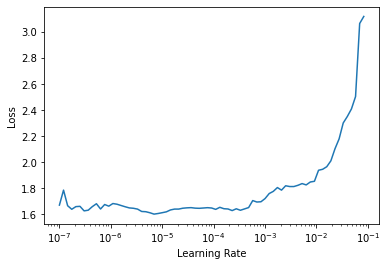

In [19]:
learn.lr_find(suggestions=True)

In [20]:
learn.fit_one_cycle(1, lr_max=7e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.151728,0.951163,0.592000,0.574056,0.578043,0.575234,05:23


In [21]:
learn.show_results(learner=learn, max_n=2, trunc_at=1500)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,category,target
0,"Die Qualität meiner neuen Hausschuhe ist, wenn ich das nach drei Tagen schon sagen kann, sehr gut. Durch den sehr weichen Stoff ""schmeicheln"" sie regelrecht den Füßen. Es lässt sich wunderbar darauf laufen und -besonders wichtig für mich- sie halten auch schön warm. Was mir nicht gefällt, und deshalb ziehe ich auch einen Stern ab, ist die hintere Umrandung des Obermaterials. Hausschuhe sind ja hinten eigentlich flach, sodass ich schön in den Schuh rein- und rausschlüpfen kann. Durch die 1 cm Kante, die wahrscheinlich deshalb eingearbeitet wurde, um mehr Halt im Schuh zu haben, macht mich beim Treppensteigen sehr unsicher. Obwohl der Schuh an sich wunderbar passt, gibt mir die hintere Kante das Gefühl, jederzeit beim Laufen aus dem Schuh zu rutschen. Und beim Treppensteigen verstärkt sich dieses Gefühl. Ein klarer Minuspunkt; obwohl das sehr subjektiv ist. Manche werden wahrscheinlich nicht verstehen, was ich damit meine. Für knapp 20 Euro habe ich jedenfalls einen tollen Gegenwert erhalten. Meine letzten Hausschuhe, für die ich hier bei Amazon seinerzeit für knapp 40 Euro bezahlt habe, sind nach drei Jahren total aus",4,3
1,"Da ich unsere Frühstücksbrötchen gerne selber backe, habe ich mir das Baguetteblech besorgt. Das Blech ist wie abgebildet und funktioniert super. Passt genau auf ein Backblech. Reinigung ist sehr leicht, ich habe übrig gebliebene Mehl einfach mit Wasser abgewaschen. Einfetten war nicht von Nöten. Ich habe das Blech nur mit Mehl bestäubt, bevor ich die Brötchen drauf gelegt habe. Einen Stern gibt es Abzug, da bei der Lieferung bereits einige Kratzer in der Beschichtung waren. Ansonsten bin ich bisher sehr zufrieden! Nachtrag - Änderung der Punktezahl: Mittlerweile bin ich nicht mehr so von dem Backblech angetan. Der Teig bleibt immer öfter kleben und zuletzt waren die Brötchen unten sogar schwarz gefärbt. Das war nicht verbrannt sondern vom Backblech, ich weiß nicht ob sich die Beschichtung löst, oder ob das die Farbe ist. Aber das ist mit Sicherheit nicht gesund. Deswegen nur noch 2 Sterne!",2,3


We'll freeze all the layers with the exception of the decoder and classification_head layers (the last 2)

In [22]:
learn.freeze_to(-2)

SuggestedLRs(lr_min=1.4454397387453355e-06, lr_steep=9.12010818865383e-07)

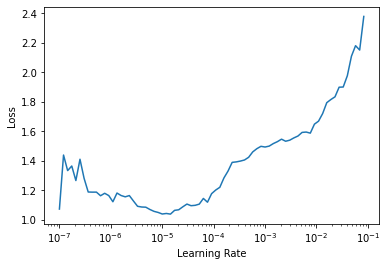

In [23]:
learn.lr_find(suggestions=True)

In [24]:
learn.fit_one_cycle(3, lr_max=slice(2e-8, 2e-7))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.020526,0.942416,0.612000,0.590443,0.597485,0.591900,10:13
1,1.020601,0.935697,0.612000,0.593317,0.598285,0.594764,10:13
2,1.063076,0.934123,0.616000,0.597113,0.602207,0.598684,10:13


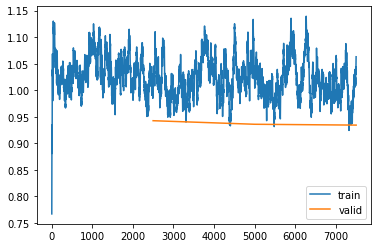

In [25]:
learn.recorder.plot_loss()

In [26]:
learn.show_results(learner=learn, max_n=2, trunc_at=1500)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,category,target
0,"Die Qualität meiner neuen Hausschuhe ist, wenn ich das nach drei Tagen schon sagen kann, sehr gut. Durch den sehr weichen Stoff ""schmeicheln"" sie regelrecht den Füßen. Es lässt sich wunderbar darauf laufen und -besonders wichtig für mich- sie halten auch schön warm. Was mir nicht gefällt, und deshalb ziehe ich auch einen Stern ab, ist die hintere Umrandung des Obermaterials. Hausschuhe sind ja hinten eigentlich flach, sodass ich schön in den Schuh rein- und rausschlüpfen kann. Durch die 1 cm Kante, die wahrscheinlich deshalb eingearbeitet wurde, um mehr Halt im Schuh zu haben, macht mich beim Treppensteigen sehr unsicher. Obwohl der Schuh an sich wunderbar passt, gibt mir die hintere Kante das Gefühl, jederzeit beim Laufen aus dem Schuh zu rutschen. Und beim Treppensteigen verstärkt sich dieses Gefühl. Ein klarer Minuspunkt; obwohl das sehr subjektiv ist. Manche werden wahrscheinlich nicht verstehen, was ich damit meine. Für knapp 20 Euro habe ich jedenfalls einen tollen Gegenwert erhalten. Meine letzten Hausschuhe, für die ich hier bei Amazon seinerzeit für knapp 40 Euro bezahlt habe, sind nach drei Jahren total aus",4,3
1,"Die Lampe machte zunächst einen ordentlichen Eindruck. Jedoch waren einige LEDs bereits bei der Auslieferung defekt. Der daraufhin kontaktierte Lieferant ignorierte mein Anschreiben. Die dazugehörige Zeitschaltuhr hat alle paar Wochen den Dienst quittiert. Da ich nicht so häufig in den Keller gehe, in dem die Lampe bei der Überwinterung Licht spenden sollte, stellte ich dies meist - offenbar jeweils einige Tage nach dem Ausfall fest - da die Pflanzen kurz vor dem krepieren waren. Die Zeitschaltuhr ließ sich mehrmals wieder aktivieren, ist nun aber nach wenigen Monaten ganz defekt, die Lampe lässt sich nicht mehr einschalten. Die Pflanzen sind nun alle eingegangen. Ich rate dringend von dem Kauf des Artikels ab.",1,1


## Inference

In [27]:
txt = tst_df.review_body[0]
print(txt)
learn.blurr_predict(txt)

Leider, leider nach einmal waschen ausgeblichen . Es sieht super hübsch aus , nur leider stinkt es ganz schrecklich und ein Waschgang in der Maschine ist notwendig ! Nach einem mal waschen sah es aus als wäre es 10 Jahre alt und hatte 1000 e von Waschgängen hinter sich :( echt schade !


[(('1',),
  (#1) [tensor(0)],
  (#1) [tensor([0.5725, 0.3474, 0.0716, 0.0067, 0.0018])])]

In [28]:
txts = list(tst_df.review_body.values[1:10])
print(txts)
learn.blurr_predict(txts)

['zunächst macht der Anker Halter einen soliden Eindruck. Die Magnethalterung ist auch brauchbar. Was gar nicht geht ist die Tatsache, dass die Halterung für runde Lüftungsdüsen, anders als vom Hersteller beschrieben, nicht geeignet ist! Ständig fällt das Smartphone runter. Durch das häufige Wiederanbringen ist nun auch die Gummierung kaputt, was zur Folge hat, dass die Lüftungsdüse schön zerkratzt wird! Also Schrott, der auch noch mein Auto beschädigt! Für mich ist das nicht brauchbar!', 'Siegel sowie Verpackung war beschädigt und ware war gebraucht mit Verschleiß und Fingerabdrücke. Zurück geschickt und bessere qualitativere Artikel gekauft.', 'Habe dieses Produkt NIE erhalten und das Geld wurde nicht rückerstattet!!!!!!!', 'Die Träger sind schnell abgerissen', 'Druckbild ist leider nicht akzeptabel. Die kompletten seiten werden grau eingefärbt. Verkäufer antwortet nicht auf Emails. Deshalb absolut nicht empfehlenswert.', '🤬🤬🤬 Stoff löst sich nach kurzer Zeit', 'Beim zweiten Gebrauch

[(('2',),
  (#1) [tensor(1)],
  (#1) [tensor([0.1873, 0.5228, 0.2539, 0.0327, 0.0032])]),
 (('1',),
  (#1) [tensor(0)],
  (#1) [tensor([0.6606, 0.2255, 0.0867, 0.0233, 0.0038])]),
 (('1',),
  (#1) [tensor(0)],
  (#1) [tensor([9.5275e-01, 4.1451e-02, 5.0995e-03, 3.2897e-04, 3.6943e-04])]),
 (('1',),
  (#1) [tensor(0)],
  (#1) [tensor([0.3692, 0.2738, 0.2347, 0.0907, 0.0316])]),
 (('1',),
  (#1) [tensor(0)],
  (#1) [tensor([8.1323e-01, 1.5297e-01, 3.0495e-02, 2.6044e-03, 6.9975e-04])]),
 (('4',),
  (#1) [tensor(3)],
  (#1) [tensor([0.0447, 0.1097, 0.2021, 0.3402, 0.3033])]),
 (('1',),
  (#1) [tensor(0)],
  (#1) [tensor([0.6773, 0.1921, 0.0808, 0.0320, 0.0179])]),
 (('3',),
  (#1) [tensor(2)],
  (#1) [tensor([0.1179, 0.2596, 0.4055, 0.1970, 0.0200])]),
 (('1',),
  (#1) [tensor(0)],
  (#1) [tensor([0.6736, 0.2547, 0.0619, 0.0078, 0.0020])])]

Well that's it!  

I hope this article helps your fastai, huggingface, blurr out, and hey, if I'm doing something wrong above please let me know!  I'm far from perfect :)

For more information on the MBart/MBar-50 architecture, see the huggingface docs [here](https://huggingface.co/transformers/model_doc/mbart.html).